In [42]:
# Importa las librerías necesarias

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths

pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Lee los datos del difractograma, el ruido de fondo y las bases de datos

# difractograma
raw_data = pd.read_csv('https://raw.githubusercontent.com/SantiagoJulioD/LabAv2/refs/heads/main/La2O3junio3.csv',names=['2Theta','I'])
# fondo
bg = pd.read_csv('https://raw.githubusercontent.com/SantiagoJulioD/LabAv2/refs/heads/main/background.csv',names=['2Theta','I'])
# bases de datos
db = pd.read_csv('https://raw.githubusercontent.com/SantiagoJulioD/LabAv2/refs/heads/main/AMS_La2O3.csv')

In [45]:
# Los datos del fondo se ajustan a una exponencial usando curve_fit

func = lambda x,a,b,c: a*np.exp(-b*x)+c

pars,_ = curve_fit(func,bg['2Theta'],bg['I'])

noise = lambda x: func(x,*pars)

bg_fit = pd.DataFrame()
bg_fit['2Theta'] = raw_data['2Theta']
bg_fit['I'] = noise(bg_fit['2Theta'])


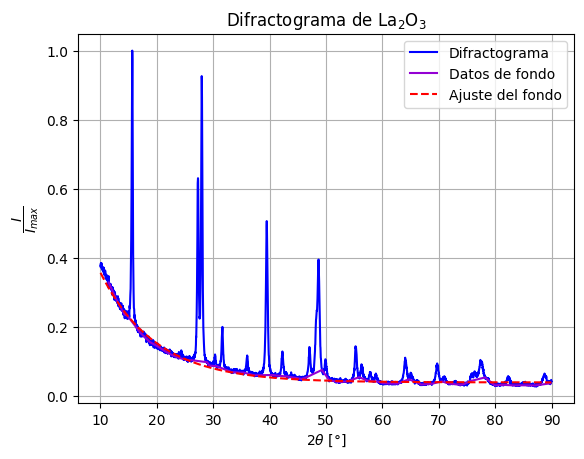

In [46]:
# Gráfica del difractograma

plt.plot(raw_data['2Theta'],raw_data['I']/np.max(raw_data['I'].values),'b',label='Difractograma')
plt.plot(bg['2Theta'],bg['I']/np.max(raw_data['I'].values),'darkviolet',label='Datos de fondo')
plt.plot(bg_fit['2Theta'],bg_fit['I']/np.max(raw_data['I'].values),'r--',label='Ajuste del fondo')
plt.title(r'Difractograma de La$_2$O$_3$')
plt.xlabel(r'$2\theta$ [°]')
plt.ylabel(r'$\dfrac{I}{I_{max}}$')
plt.legend()
plt.grid()

plt.savefig('raw_xrd.png')

In [48]:
# Se resta el ajuste de los datos de fondo a los datos en bruto para poder 
# hacer la identificación de los picos correctamente

filtered_data = pd.DataFrame()
filtered_data['2Theta'] = raw_data['2Theta']
filtered_data['I'] = raw_data['I']-bg_fit['I']

# normalización
filtered_data['I'] = filtered_data['I']/np.max(filtered_data['I'])

In [49]:
# Picos de la base de datos 

db['Norm_Intensity'] = db['INTENSITY']/np.max(db['INTENSITY'])
db

,2-THETA,INTENSITY,D-SPACING,H,K,L,Multiplicity,Norm_Intensity
0,14.47,6.09,6.1200,0,0,1,2,0.105748
1,26.18,17.96,3.4035,1,0,0,6,0.311860
2,29.18,15.34,3.0600,0,0,2,2,0.266366
3,30.04,57.59,2.9745,0,1,1,6,1.000000
4,30.04,42.41,2.9745,1,0,1,6,0.736413
5,39.61,9.30,2.2755,0,1,2,6,0.161486
6,39.61,9.30,2.2755,1,0,2,6,0.161486
7,46.20,16.18,1.9650,1,1,0,3,0.280952
8,52.28,7.75,1.7498,0,1,3,6,0.134572
9,52.28,10.03,1.7498,1,0,3,6,0.174162


In [50]:
# Se encuentran los picos del difractograma usando find_peaks

peak_ind = find_peaks(filtered_data['I'].values,height=0.25)
peaks = filtered_data.iloc[peak_ind[0]]
peaks['h'] = [1,0,1,1,1]
peaks['k'] = [0,0,0,0,1]
peaks['l'] = [0,2,1,2,0]

peaks

,2Theta,I,h,k,l
214,15.643191,0.935514,1,0,0
658,27.302882,0.642625,0,0,2
683,27.959396,1.000000,1,0,1
1122,39.487784,0.539844,1,0,2
1472,48.678982,0.417952,1,1,0


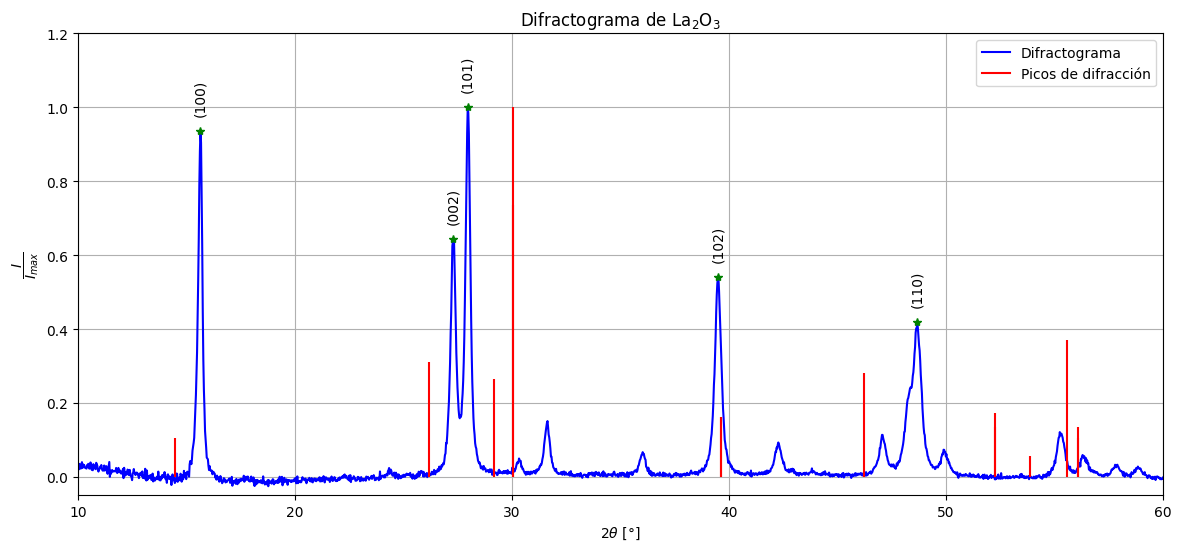

In [51]:
# Gráfica del difractograma filtrado

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(filtered_data['2Theta'],filtered_data['I'],color='b',label='Difractograma')
for i in range(len(db['2-THETA'].values)):
    ax.vlines(db.iloc[i]['2-THETA'],0,db.iloc[i]['Norm_Intensity'],color='r') 

# Gráfica de los picos de la base de datos

ax.plot(peaks['2Theta'],peaks['I'],'g*')
for i in range(len(peaks['2Theta'].values)):
    h = peaks['h'].values[i]
    k = peaks['k'].values[i]
    l = peaks['l'].values[i]
    ax.text(peaks['2Theta'].values[i],peaks['I'].values[i]+0.05,s=f'({h}{k}{l})',ha='center',rotation=90)

ax.plot(0,0,'r',label='Picos de difracción')

ax.set(ylim=(-0.05,1.2),xlim=(10,60),title = r'Difractograma de La$_2$O$_3$',xlabel=r'$2\theta$ [°]',ylabel=r'$\dfrac{I}{I_{max}}$')
ax.legend()
ax.grid()

plt.savefig('peaks.png')


In [ ]:
# Parámetros de red

a = 3.95700 # angstrom
b = 3.95715 # angstrom
c = 6.13800 # angstrom

alpha = 90.
beta = 90.
gamma = 120.

In [52]:
# Los anchos a media altura se obtienen con peak_widths

results_half = peak_widths(raw_data['I'].values, peak_ind[0], rel_height=0.5)

In [53]:
# Conversión del índice del dataframe al ángulo

def ind2angle(index):
    b = filtered_data['2Theta'].values[0]
    m = (filtered_data['2Theta'].values[-1]-filtered_data['2Theta'].values[0])/(len(filtered_data)-1)
    return b+m*index

ind2angle = np.vectorize(ind2angle)

In [54]:
# Ancho angular de los picos

Bs = ind2angle(results_half)
Bs[0] = Bs[3]-Bs[2]

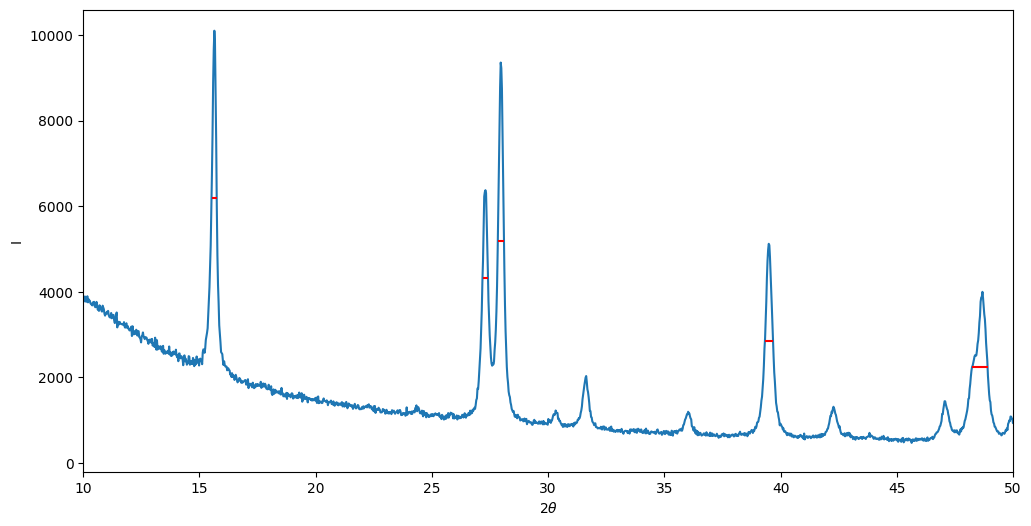

In [55]:
# Gráfica de los picos con sus anchos

plt.figure(figsize=(12,6))

plt.plot(raw_data['2Theta'].values,raw_data['I'].values)

plt.hlines(results_half[1],*Bs[2:], color="r")

plt.xlim(10,50)
plt.xlabel(r'$2\theta$')
plt.ylabel(r'I')
plt.show()


In [56]:
# Agrega el ancho de los picos al dataframe

peaks['B'] = Bs[0]

In [57]:
# Ajuste de Williamson-Hall

line = lambda x,m,b: m*x+b

xs = 4*np.sin(np.pi/180*peaks['2Theta']/2)
ys = peaks['B']*np.cos(np.pi/180*peaks['2Theta']/2)

pars2,mcov = curve_fit(line,xs,ys)

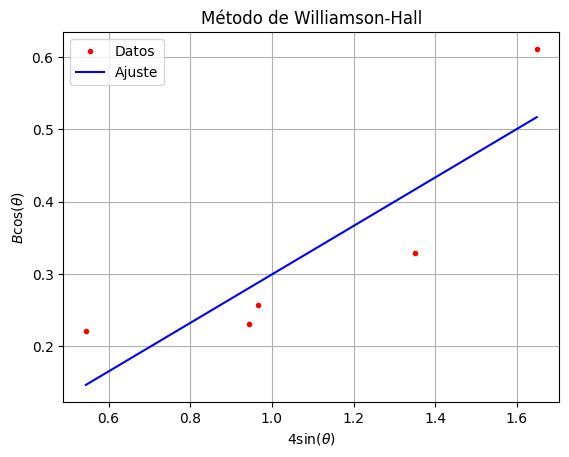

In [58]:
# Gráfica del ajuste de Williamson-Hall

xfit = np.linspace(xs.values[0],xs.values[-1])
yfit = line(xfit,*pars2)

plt.plot(xs,ys,'r.',label='Datos')
plt.plot(xfit,yfit,'b',label='Ajuste')
plt.title('Método de Williamson-Hall')
plt.xlabel(r'$4\sin(\theta)$')
plt.ylabel(r'$B\cos(\theta)$')
plt.grid()
plt.legend()
plt.savefig('wh.png')

plt.show()

In [60]:
# Tamaño del cristalito y esfuerzo interno medio

lam = 1.540598

strain = pars2[0]
size = np.abs(0.94*lam/pars2[1])
print(f'eps = ({strain}±{mcov[0,0]**0.5})')
print(f'L = ({size}±{mcov[1,1]**0.5})')

eps = (0.3356152820799361±0.10975400587365203)
L = (39.81226606732224±0.1267174548988899)
